In [31]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import datetime
import numpy as np

## Settings

In [32]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

input_path = './inputs/'
filename_exp = 'data_exp_03.csv'
filename_gaze = 'data_gaze_03.csv'
filename_video = '20230913_02.mp4'

output_path = './outputs/'
filename_position = f'position_{timestamp}.csv'
output_frame_dir = './outputs/frames/'

## Processing data

In [33]:
data_exp = pd.read_csv(input_path + filename_exp)
data_gaze = pd.read_csv(input_path + filename_gaze)

exp_timestamp = data_exp['etRecord_3.started']
exp_timestamp_clean = exp_timestamp.dropna()

first_value = exp_timestamp_clean.iloc[0]  # Get the first value
adjusted_value = [value - first_value for value in exp_timestamp_clean]
new_data = pd.DataFrame({'exp_index': adjusted_value})

gaze_timestamp = data_gaze['gaze_timestamp']
first_value = gaze_timestamp.iloc[0]
adjusted_value = [value - first_value for value in gaze_timestamp]
new_data2 = pd.DataFrame({'gaze_stamp': adjusted_value})

new_data2['norm_x'] = data_gaze['norm_pos_x']
new_data2['norm_y'] = data_gaze['norm_pos_y']

# Define the time interval for merging (e.g., +/- 1 second)
time_interval = 5.999

# Merge based on time intervals
merged_df = pd.merge_asof(
    new_data2,
    new_data,
    left_on='gaze_stamp',
    right_on='exp_index',
    direction='backward',  # Use 'backward' if you want to find the nearest exp_index value before gaze_stamp
    tolerance=time_interval
)

merged_df.to_csv(output_path+filename_position) 


## Convert video to frames

In [34]:
# Create the output directory if it doesn't exist
output_frame_dir = output_frame_dir + '/' + timestamp

os.makedirs(output_frame_dir, exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(input_path + filename_video)

# Get the frames per second (FPS) of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(f'video fps: {fps}')

frame_count = 0  # Initialize frame count

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Output every second frame (skip two out of every three frames)
    if frame_count % 3 == 0:
        # Save the frame as an image
        frame_filename = os.path.join(output_frame_dir, f'frame_{frame_count // 3:04d}.jpg')
        cv2.imwrite(frame_filename, frame)

    frame_count += 1

# Release the video capture
cap.release()


video fps: 29


## Visualization on Gaze data

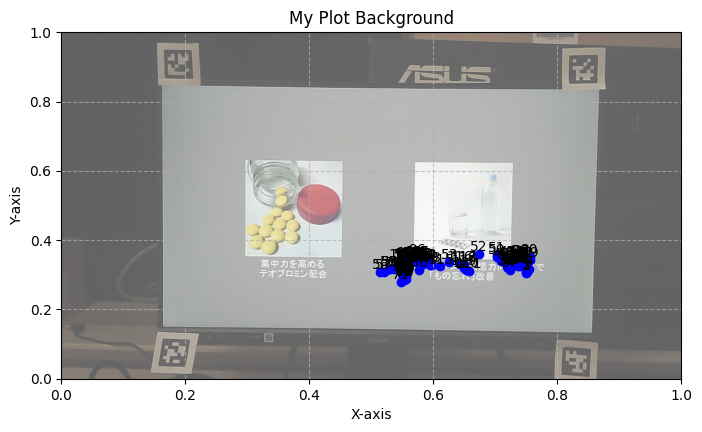

In [35]:
# Load your gaze data and timestamps from your DataFrame
merged_df = merged_df.copy()

# Define the list of seconds you want to display
display_second = 4  # Adjust this list as needed

range_init = display_second * 120
range_over = range_init + 120

# Extract relevant columns
timestamps = merged_df['gaze_stamp']

x_data = merged_df['norm_x'][range_init:range_over+1]
y_data = merged_df['norm_y'][range_init:range_over+1]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4.5))

# Set the background color
ax.set_facecolor('#f0f0f0')

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Set axis labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Set plot title
ax.set_title('My Plot Background')

# Set fixed X-axis and Y-axis limits (adjust as needed)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Scatter plot your gaze data
ax.scatter(x_data, y_data, label='Eye Tracking Data', color='blue', marker='o')

for i, (x, y) in enumerate(zip(x_data, y_data)):
    ax.text(x, y, str(i+1), ha='center', va='bottom', fontsize=10, color='black')

# Load and overlay images based on selected seconds
opacity = 0.6
image_directory = output_frame_dir  # Directory containing your saved images

frame_start = display_second * 10  # Assuming 10 frames per second
frame_end = frame_start + 10
        
display_frame = display_second * 10
image_filename = os.path.join(image_directory, f'frame_{display_frame:04d}.jpg')
if os.path.exists(image_filename):
    # Load and display the image as a background with lower opacity
    img = mpimg.imread(image_filename)
    ax.imshow(img, extent=(0, 1, 0, 1), aspect='auto', zorder=-1, alpha=opacity)

# Show the plot
plt.show()

## Test with cv2 

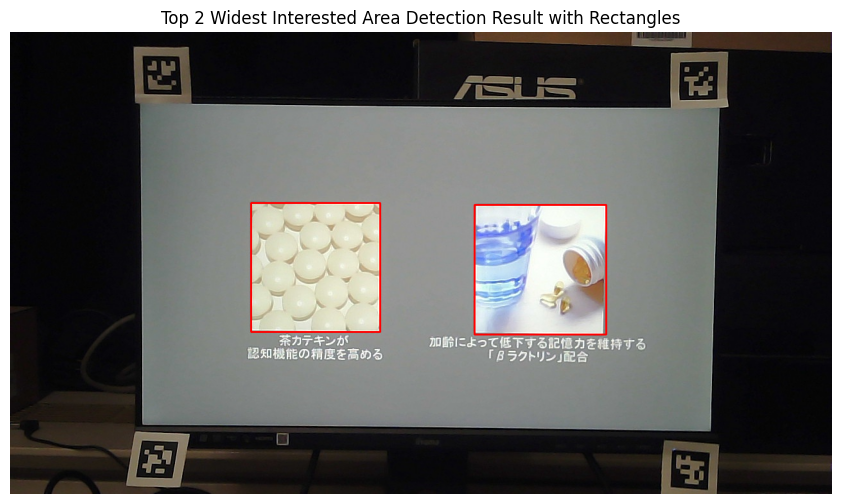

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('./outputs/frames/20230927_160946/frame_0100.jpg')

# Convert the image to the HSV color space (Hue, Saturation, Value)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for detecting colorful areas (excluding gray)
lower_color = np.array([0, 0, 0])  # Adjust these values based on your specific color
upper_color = np.array([180, 180, 180])  # Adjust these values based on your specific color

# Create a mask that separates colorful areas (excluding gray)

color_mask = cv2.inRange(hsv_image, lower_color, upper_color)

# Invert the mask to focus on less interested (black) areas
less_interested_mask = cv2.bitwise_not(color_mask)

# Find contours in the less interested (black) mask
contours, _ = cv2.findContours(less_interested_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to store the bounding rectangles around less interested (black) areas in the center
less_interested_rectangles_centered_and_ranged = []

# Calculate the center of the image
image_center_x = image.shape[1] // 2
image_center_y = image.shape[0] // 2

# Define a threshold for considering rectangles as centered
center_threshold = 0.4  # Adjust as needed

# Define the y-coordinate range
y_range_min = 0.2
y_range_max = 0.8

# Loop through the contours to find centered and ranged less interested (black) areas
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate the center of the rectangle
    rect_center_x = x + w // 2
    rect_center_y = y + h // 2
    
    # Calculate the distance between the rectangle center and the image center
    distance_to_center = np.sqrt((rect_center_x - image_center_x)**2 + (rect_center_y - image_center_y)**2)
    
    # Check if the rectangle is centered (within the threshold) and within the y-coordinate range
    if (
        distance_to_center <= center_threshold * min(image.shape[0], image.shape[1]) and
        y_range_min <= (y + h) / image.shape[0] <= y_range_max
    ):
        less_interested_rectangles_centered_and_ranged.append((x, y, w, h))

# Sort the rectangles by width in descending order
sorted_rectangles = sorted(less_interested_rectangles_centered_and_ranged, key=lambda rect: rect[2], reverse=True)

# Keep the top 2 widest rectangles
top_2_widest_rectangles = sorted_rectangles[:2]

# Draw rectangles around the top 2 widest centered and ranged less interested (black) areas on the original image
for x, y, w, h in top_2_widest_rectangles:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red color, line thickness = 2

# Display the result with the top 2 widest rectangles
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Top 2 Widest Interested Area Detection Result with Rectangles')
plt.axis('off')

plt.show()


condition = [1, 2, 3, 4] [12, 41, 34, 23]
arrow = [0, 1] [left, right]

## Reshape exp code for further integration

In [41]:
data_exp = pd.read_csv(input_path + filename_exp)

data_exp_exposure = data_exp[2:22]
data_exp_rating = data_exp[23:63]

condition = data_exp['condition'][3]
participant = data_exp['participant'][3]
session = data_exp['session'][3]

# Define a function to extract data based on condition
def extract_exposure_data(condition):
    if condition == 1:
        columns = ['participant', 'condition', 'session', 'picture1', 'picture2', 'statement1', 'statement2', 'Category', 'etRecord_3.started', 'arrow_list1']
    elif condition == 2:
        columns = ['participant', 'condition', 'session', 'picture4', 'picture1', 'statement4', 'statement1', 'Category', 'etRecord_3.started', 'arrow_list1']
    elif condition == 3:
        columns = ['participant', 'condition', 'session', 'picture3', 'picture4', 'statement3', 'statement4', 'Category', 'etRecord_3.started', 'arrow_list1']
    elif condition == 4:
        columns = ['participant', 'condition', 'session', 'picture2', 'picture3', 'statement2', 'statement3', 'Category', 'etRecord_3.started', 'arrow_list1']
    else:
        return None  # Handle invalid condition

    # Extract and return the selected columns
    return data_exp_exposure[columns]

# Example: Extract data for condition 1
data_exp_exposure_target = extract_exposure_data(condition)

def extract_rating_data(input_df):
    # Create an empty list to store the rows
    output = []

    # Iterate through the rows of the input DataFrame
    for index, row in input_df.iterrows():
        # Extract fixed columns
        participant = row['participant']
        session = row['session']
        evaluation = row['evaluation']
        Category = row['Category']
        set_num = row['set_num']

        # Determine target_image and target_statement based on set_num
        if set_num == 1:
            target_image = row['picture1']
            target_statement = row['statement1']
        elif set_num == 2:
            target_image = row['picture2']
            target_statement = row['statement2']
        elif set_num == 3:
            target_image = row['picture3']
            target_statement = row['statement3']
        elif set_num == 4:
            target_image = row['picture4']
            target_statement = row['statement4']
        else:
            # Handle the case when set_num is not 1, 2, or 3
            target_image = None
            target_statement = None

        # Create a dictionary for the row
        row_dict = {
            'participant': participant,
            'session': session,
            'Category': Category,
            'set_num': set_num,
            'target_image': target_image,
            'target_statement': target_statement,
            'evaluation': evaluation,
        }

        # Append the row dictionary to the list
        output.append(row_dict)

    # Create a DataFrame from the list of row dictionaries
    output_target = pd.DataFrame(output)

    return output_target


data_exp_rating_target = extract_rating_data(data_exp_rating)


In [43]:
condition

2.0

In [42]:
data_exp_rating_target

,participant,session,Category,set_num,target_image,target_statement,evaluation
0,520374,2,Eye,3.0,0085.jpg,ビルベリー由来のアントシアニンが現代人の目の潤いをキープ,1.0
1,520374,2,Blood,2.0,0008.jpg,モノグルコシルヘスペリジンが高めの血圧を下げるのを助ける,1.0
2,520374,2,Fat,1.0,0098.jpg,食後に1粒、サラシノール摂取で簡単糖質カット,1.0
3,520374,2,Blood,1.0,0032.jpg,毎日フィロキノン生活で心血管疾患を予防,1.0
4,520374,2,Bone,4.0,0075.jpg,クルクミンが加齢により衰えるひざ関節機能を維持,1.0
5,520374,2,Cog,1.0,0006.jpg,集中力を高めるテオブロミン配合,1.0
6,520374,2,Cog,2.0,0056.jpg,プラズマローゲンが脳神経細胞を保護し、認知機能の低下を阻止,1.0
7,520374,2,Fat,2.0,0070.jpg,グルコマンナンが食欲を抑制、日々の食べ過ぎを防止,1.0
8,520374,2,Bone,3.0,0049.jpg,大豆イソフラボンで骨の健康を維持,1.0
9,520374,2,Eye,4.0,0035.jpg,目のピント調節機能を保つアスタキサンチンを1日摂取目安量の6mg配合,1.0


In [ ]:
data_exp_exposure_target

,participant,condition,session,picture1,picture2,statement1,statement2,Category,etRecord_3.started,arrow_list1
2,520374,2.0,2,0032.jpg,0059.jpg,毎日フィロキノン生活で心血管疾患を予防,ニコチン酸が末梢の血行を促進、さらさら血液に,Blood,23.296535,0
3,520374,2.0,2,0006.jpg,0063.jpg,集中力を高めるテオブロミン配合,不足しがちなホスファチジルコリンが記憶保持をサポート,Cog,29.463154,1
4,520374,2.0,2,0021.jpg,0056.jpg,茶カテキンが認知機能の精度を高める,プラズマローゲンが脳神経細胞を保護し、認知機能の低下を阻止,Cog,35.696579,1
5,520374,2.0,2,0100.jpg,0008.jpg,GABAを1杯当たり50mg含有し健康な血圧をサポート,モノグルコシルヘスペリジンが高めの血圧を下げるのを助ける,Blood,41.863148,0
6,520374,2.0,2,0074.jpg,0022.jpg,1粒12㎎のDHA・ルテインで疲れた目に栄養補給,レチノール・トコトリエノール贅沢配合、内側から疲れ目をケア,Eye,48.079518,0
7,520374,2.0,2,0098.jpg,0077.jpg,食後に1粒、サラシノール摂取で簡単糖質カット,代謝を助けるチアミンが糖質・脂質を無駄なく分解,Fat,54.213499,0
8,520374,2.0,2,0069.jpg,0083.jpg,ビタミンK一日摂取目安量配合、骨密度を維持して健康な毎日を,プロテオグリカンで軟骨ケア、 関節の不快感とおさらば,Bone,60.329513,1
9,520374,2.0,2,0087.jpg,0070.jpg,代謝を高めて内臓脂肪を減らすサラシノール配合,グルコマンナンが食欲を抑制、日々の食べ過ぎを防止,Fat,66.579275,1
10,520374,2.0,2,0076.jpg,0040.jpg,ルテインとゼアキサンチンのダブル配合でぼやけを緩和,アントシアニンが刺激から目を保護し、視力低下を予防,Eye,72.712433,1
11,520374,2.0,2,0041.jpg,0002.jpg,関節・骨の老化をカバー、カルシフェロールで丈夫な骨活,MBPとカルシウムの同時摂取で健康な骨づくり,Bone,78.846673,0


In [ ]:
data_exp_exposure

,num,picture1,picture2,picture3,picture4,Category,statement1,statement2,statement3,statement4,...,key_resp_3.started,key_resp_3.keys,key_resp_3.rt,participant,session,date,expName,psychopyVersion,frameRate,Unnamed: 83
2,0.0,0032.jpg,0059.jpg,0027.jpg,0012.jpg,Blood,毎日フィロキノン生活で心血管疾患を予防,ニコチン酸が末梢の血行を促進、さらさら血液に,血圧低下に効果的なカカオポリフェノール配合,血中コレステロール低下作用をもつ天然アミノ酸SMCS含有,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
3,4.0,0006.jpg,0063.jpg,0078.jpg,0028.jpg,Cog,集中力を高めるテオブロミン配合,不足しがちなホスファチジルコリンが記憶保持をサポート,ビフィズス菌で腸からはじめる記憶対策,ピロロキノリンキノンの記憶力向上効果で「もの忘れ」改善,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
4,5.0,0021.jpg,0056.jpg,0086.jpg,0017.jpg,Cog,茶カテキンが認知機能の精度を高める,プラズマローゲンが脳神経細胞を保護し、認知機能の低下を阻止,認知機能回復効果を持つタキシフォリンがアルツハイマー予防に機能,加齢によって低下する記憶力を維持する「βラクトリン」配合,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
5,1.0,0100.jpg,0008.jpg,0064.jpg,0024.jpg,Blood,GABAを1杯当たり50mg含有し健康な血圧をサポート,モノグルコシルヘスペリジンが高めの血圧を下げるのを助ける,ゴマから生まれた「ゴマペプチド」を含み、血圧が高めの方に最適,ビオチンのはたらきで血糖値を適正にコントロール,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
6,6.0,0074.jpg,0022.jpg,0085.jpg,0091.jpg,Eye,1粒12㎎のDHA・ルテインで疲れた目に栄養補給,レチノール・トコトリエノール贅沢配合、内側から疲れ目をケア,ビルベリー由来のアントシアニンが現代人の目の潤いをキープ,リコピンの強力な抗酸化作用でクリアな視界に,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
7,8.0,0098.jpg,0077.jpg,0019.jpg,0007.jpg,Fat,食後に1粒、サラシノール摂取で簡単糖質カット,代謝を助けるチアミンが糖質・脂質を無駄なく分解,脂肪の代謝を助けるポリメトキシフラボンで内臓脂肪をすっきり,モノグルコシルヘスペリジンが余分な脂質を燃焼させる,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
8,2.0,0069.jpg,0083.jpg,0049.jpg,0084.jpg,Bone,ビタミンK一日摂取目安量配合、骨密度を維持して健康な毎日を,プロテオグリカンで軟骨ケア、 関節の不快感とおさらば,大豆イソフラボンで骨の健康を維持,糖転移へスペリジンが骨形成を促し、加齢による骨量減少を予防,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
9,9.0,0087.jpg,0070.jpg,0093.jpg,0062.jpg,Fat,代謝を高めて内臓脂肪を減らすサラシノール配合,グルコマンナンが食欲を抑制、日々の食べ過ぎを防止,脂肪分解酵素を活性化させるケルセチン配糖体を含む,食欲抑制効果をもつ酵母ペプチドで太りにくい食事習慣に,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
10,7.0,0076.jpg,0040.jpg,0048.jpg,0035.jpg,Eye,ルテインとゼアキサンチンのダブル配合でぼやけを緩和,アントシアニンが刺激から目を保護し、視力低下を予防,クロセチンが目のピント調節をサポート,目のピント調節機能を保つアスタキサンチンを1日摂取目安量の6mg配合,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
11,3.0,0041.jpg,0002.jpg,0061.jpg,0075.jpg,Bone,関節・骨の老化をカバー、カルシフェロールで丈夫な骨活,MBPとカルシウムの同時摂取で健康な骨づくり,体内吸収性に優れた「卵殻由来のカルシウム」,クルクミンが加齢により衰えるひざ関節機能を維持,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN


In [ ]:
data_exp_rating

,num,picture1,picture2,picture3,picture4,Category,statement1,statement2,statement3,statement4,...,key_resp_3.started,key_resp_3.keys,key_resp_3.rt,participant,session,date,expName,psychopyVersion,frameRate,Unnamed: 83
23,6.0,0074.jpg,0022.jpg,0085.jpg,0091.jpg,Eye,1粒12㎎のDHA・ルテインで疲れた目に栄養補給,レチノール・トコトリエノール贅沢配合、内側から疲れ目をケア,ビルベリー由来のアントシアニンが現代人の目の潤いをキープ,リコピンの強力な抗酸化作用でクリアな視界に,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
24,1.0,0100.jpg,0008.jpg,0064.jpg,0024.jpg,Blood,GABAを1杯当たり50mg含有し健康な血圧をサポート,モノグルコシルヘスペリジンが高めの血圧を下げるのを助ける,ゴマから生まれた「ゴマペプチド」を含み、血圧が高めの方に最適,ビオチンのはたらきで血糖値を適正にコントロール,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
25,8.0,0098.jpg,0077.jpg,0019.jpg,0007.jpg,Fat,食後に1粒、サラシノール摂取で簡単糖質カット,代謝を助けるチアミンが糖質・脂質を無駄なく分解,脂肪の代謝を助けるポリメトキシフラボンで内臓脂肪をすっきり,モノグルコシルヘスペリジンが余分な脂質を燃焼させる,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
26,0.0,0032.jpg,0059.jpg,0027.jpg,0012.jpg,Blood,毎日フィロキノン生活で心血管疾患を予防,ニコチン酸が末梢の血行を促進、さらさら血液に,血圧低下に効果的なカカオポリフェノール配合,血中コレステロール低下作用をもつ天然アミノ酸SMCS含有,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
27,3.0,0041.jpg,0002.jpg,0061.jpg,0075.jpg,Bone,関節・骨の老化をカバー、カルシフェロールで丈夫な骨活,MBPとカルシウムの同時摂取で健康な骨づくり,体内吸収性に優れた「卵殻由来のカルシウム」,クルクミンが加齢により衰えるひざ関節機能を維持,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
28,4.0,0006.jpg,0063.jpg,0078.jpg,0028.jpg,Cog,集中力を高めるテオブロミン配合,不足しがちなホスファチジルコリンが記憶保持をサポート,ビフィズス菌で腸からはじめる記憶対策,ピロロキノリンキノンの記憶力向上効果で「もの忘れ」改善,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
29,5.0,0021.jpg,0056.jpg,0086.jpg,0017.jpg,Cog,茶カテキンが認知機能の精度を高める,プラズマローゲンが脳神経細胞を保護し、認知機能の低下を阻止,認知機能回復効果を持つタキシフォリンがアルツハイマー予防に機能,加齢によって低下する記憶力を維持する「βラクトリン」配合,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
30,9.0,0087.jpg,0070.jpg,0093.jpg,0062.jpg,Fat,代謝を高めて内臓脂肪を減らすサラシノール配合,グルコマンナンが食欲を抑制、日々の食べ過ぎを防止,脂肪分解酵素を活性化させるケルセチン配糖体を含む,食欲抑制効果をもつ酵母ペプチドで太りにくい食事習慣に,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
31,2.0,0069.jpg,0083.jpg,0049.jpg,0084.jpg,Bone,ビタミンK一日摂取目安量配合、骨密度を維持して健康な毎日を,プロテオグリカンで軟骨ケア、 関節の不快感とおさらば,大豆イソフラボンで骨の健康を維持,糖転移へスペリジンが骨形成を促し、加齢による骨量減少を予防,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
32,7.0,0076.jpg,0040.jpg,0048.jpg,0035.jpg,Eye,ルテインとゼアキサンチンのダブル配合でぼやけを緩和,アントシアニンが刺激から目を保護し、視力低下を予防,クロセチンが目のピント調節をサポート,目のピント調節機能を保つアスタキサンチンを1日摂取目安量の6mg配合,...,NaN,NaN,NaN,520374,2,2023-09-13_17h45.54.640,eye20,2022.2.5,60.01468,NaN
